In [79]:
from astroNN.datasets import galaxy10sdss
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import pandas as pd
import seaborn as sns
import numpy as np
from keras import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import torchvision.transforms as transform




In [80]:
images, labels=galaxy10sdss.load_data()

images=images.astype(np.float32)
Gal_train, Gal_test, lab_train, lab_test=train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=5)
Gal_train=Gal_train/255.0
Gal_test=Gal_test/255.0

C:\Users\Alexb\.astroNN\datasets\Galaxy10.h5 was found!


In [81]:
Gal_train.shape, Gal_test.shape, lab_train.shape, lab_test.shape

((17428, 69, 69, 3), (4357, 69, 69, 3), (17428,), (4357,))

In [82]:

features=[feature for feature in galaxy10sdss.Galaxy10Class.values()]
    
for feature in features:
    print(feature)

Disk, Face-on, No Spiral
Smooth, Completely round
Smooth, in-between round
Smooth, Cigar shaped
Disk, Edge-on, Rounded Bulge
Disk, Edge-on, Boxy Bulge
Disk, Edge-on, No Bulge
Disk, Face-on, Tight Spiral
Disk, Face-on, Medium Spiral
Disk, Face-on, Loose Spiral


In [83]:
Ntransform=transform.Compose([transform.ToTensor()])

In [84]:
class Gal10Dataset(Dataset):
    def __init__(self, gal_data, labels, transform=None):
        self.gal_data=gal_data
        self.labels=labels
        self.transform=transform
    def __len__(self):
        return len(self.gal_data)
    def __getitem__(self,idx):
        sample=self.gal_data[idx]
        label=self.labels[idx]
        if self.transform:
            sample=self.transform(sample)
        return sample, label

In [85]:
train_set=Gal10Dataset(Gal_train, lab_train, transform=Ntransform)
test_set=Gal10Dataset(Gal_test,lab_test, transform=Ntransform)

imgs=torch.stack([img for img, _ in train_set], dim=0)
mean=imgs.view(1, -1).mean(dim=1)
std=imgs.view(1, -1).std(dim=1)
print(mean, std)

resize_norm=transform.Compose([transform.ToTensor(), transform.Resize((32, 32)), transform.Normalize(mean=mean, std=std)])

train_set=Gal10Dataset(Gal_train, lab_train, transform=resize_norm)
test_set=Gal10Dataset(Gal_test, lab_test, transform=resize_norm)

train_loader=DataLoader(train_set, batch_size=32, shuffle=True)
test_loader=DataLoader(test_set, batch_size=32, shuffle=True)

tensor([0.0910]) tensor([0.1267])


In [86]:
len(train_loader), len(test_loader)

(545, 137)

In [87]:
print(train_loader)
print(len(train_loader.dataset))
print(len(train_loader))
print(train_loader.batch_size)
for x, y in train_loader:
    print(x.shape, x.dtype, y.shape)
    break

17428
545
32
torch.Size([32, 3, 32, 32]) torch.float32 torch.Size([32])


In [88]:
for images, labels in train_loader:
    print(images.shape, images.dtype)
    print(labels.shape, labels.dtype)
    break

torch.Size([32, 3, 32, 32]) torch.float32
torch.Size([32]) torch.uint8


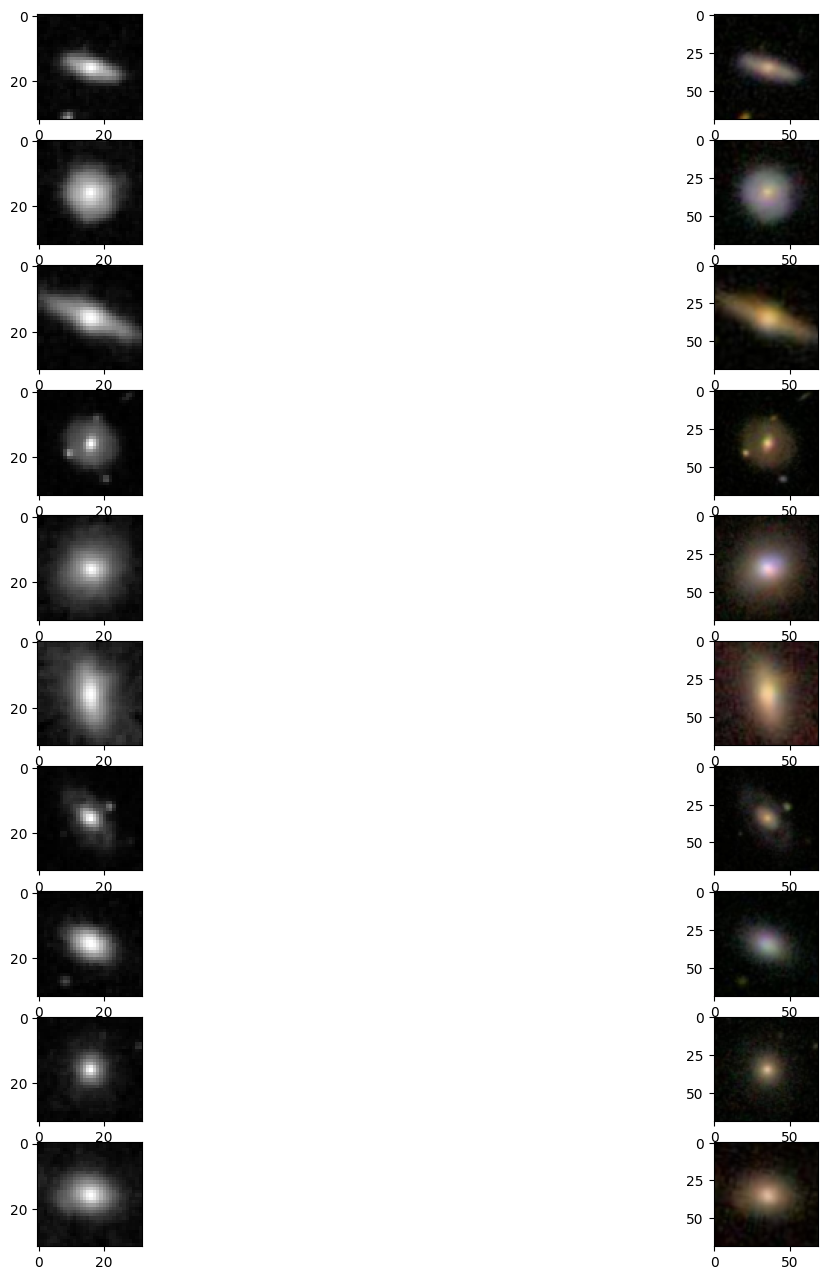

In [89]:

fig, axs=plt.subplots(10, 2, figsize=(16,16))
for i in range(10):
    axs[i, 0].imshow(train_loader.dataset[i][0][0], cmap='gray')
    axs[i, 1].imshow(Gal_train[i], cmap='gray')

In [90]:
#The convolutional NN
import torch.nn as nn
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_class=num_classes
        self.feature=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=self.num_class)
        )
        
    
    def forward(self, x):
        return self.classifier(self.feature(x))

In [91]:
device=(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [92]:
from torchinfo import summary
model=LeNet5(20)
summary(model=model, input_size=(1, 3, 32, 32), col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 3, 32, 32]       [1, 20]              --                   True
├─Sequential (feature)                   [1, 3, 32, 32]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 3, 32, 32]       [1, 6, 28, 28]       456                  True
│    └─Tanh (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (3)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─Tanh (4)                          [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─AvgPool2d (5)                     [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Sequential (classifi

In [93]:
num_features=len(features)
learning_rate=0.001


model=LeNet5(num_classes=num_features).to(device=device)
loss_fn=nn.CrossEntropyLoss()

optim=torch.optim.Adam(model.parameters(),lr=learning_rate)

total_steps=len(train_loader)

In [94]:
def train(train_loader, model, optimizer, loss):
    correct=0
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data, target=data.to(device), target.to(device)
        
        output=model(data)
        loss=loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred=output.argmax(dim=1, keepdim=True)
        correct+=pred.eq(target.view_as(pred)).sum().item()
        
        if batch%100==0:
            print(f'Step: {batch*len(data)}/{len(train_loader.dataset)} Loss: {loss:.3f}')
    
    return 100*correct/len(train_loader.dataset)

In [95]:
def test(test_loader, model, loss_fn):
    model.eval()
    test_loss=0.0
    correct=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target=data.to(device), target.to(device)
            
            output=model(data)
            test_loss+=loss_fn(output, target).item()
            prediction=output.argmax(dim=1, keepdim=True)
            correct+=prediction.eq(target.view_as(prediction)).sum().item()
    test_loss/=len(test_loader)
    acc=100*correct/len(test_loader.dataset)
    print(f"Test loss: {test_loss:.3f} Accuracy: {acc:.3f}")
    return acc

In [96]:
train_acc=[]
test_acc=[]
epochs=20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n======================================")
    train_acc.append(train(train_loader, model, optim, loss_fn))
    test_acc.append(test(test_loader, model, loss_fn))
    
print("Done!")
    

Epoch 1
Step: 0/17428 Loss: 2.328
Step: 3200/17428 Loss: 1.368
Step: 6400/17428 Loss: 1.627
Step: 9600/17428 Loss: 1.335
Step: 12800/17428 Loss: 1.100
Step: 16000/17428 Loss: 0.869
Test loss: 0.988 Accuracy: 63.668
Epoch 2
Step: 0/17428 Loss: 0.899
Step: 3200/17428 Loss: 1.016
Step: 6400/17428 Loss: 0.962
Step: 9600/17428 Loss: 0.936
Step: 12800/17428 Loss: 0.709
Step: 16000/17428 Loss: 1.180
Test loss: 0.916 Accuracy: 66.032
Epoch 3
Step: 0/17428 Loss: 0.977
Step: 3200/17428 Loss: 0.815
Step: 6400/17428 Loss: 1.071
Step: 9600/17428 Loss: 0.932
Step: 12800/17428 Loss: 0.625
Step: 16000/17428 Loss: 0.676
Test loss: 0.857 Accuracy: 67.799
Epoch 4
Step: 0/17428 Loss: 0.903
Step: 3200/17428 Loss: 0.976
Step: 6400/17428 Loss: 0.635
Step: 9600/17428 Loss: 0.736
Step: 12800/17428 Loss: 0.999
Step: 16000/17428 Loss: 0.946
Test loss: 0.815 Accuracy: 69.589
Epoch 5
Step: 0/17428 Loss: 0.846
Step: 3200/17428 Loss: 0.800
Step: 6400/17428 Loss: 0.501
Step: 9600/17428 Loss: 0.674
Step: 12800/17428 L

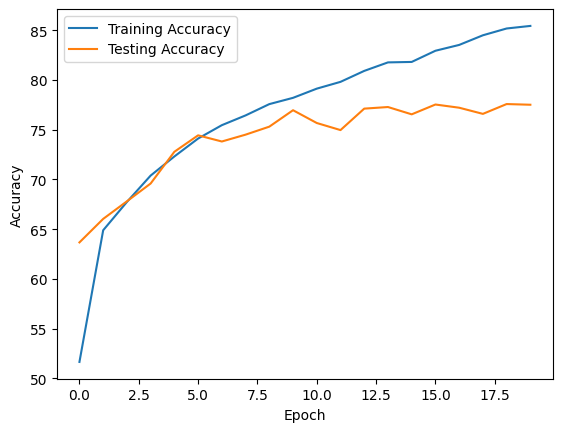

In [97]:
epoch=range(0,epochs)
plt.plot(epoch, train_acc, label="Training Accuracy")
plt.plot(epoch, test_acc, label="Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [98]:
print(train_acc)
print(test_acc)

[51.65251319715401, 64.88983245352307, 67.73582740417719, 70.3867339912784, 72.30892816157906, 74.11062657792058, 75.45329355060822, 76.4344732614184, 77.57057608446179, 78.20174431948588, 79.12554509983934, 79.80835437227451, 80.91002983704384, 81.76497590084921, 81.81087904521459, 82.93550608216663, 83.52077117282533, 84.49047509754418, 85.17328436997934, 85.43148955703465]
[63.667661234794586, 66.03167316961212, 67.7989442276796, 69.58916685792977, 72.7794353913243, 74.4319485884783, 73.81225613954555, 74.5008033050264, 75.30410833142071, 76.9566215285747, 75.67133348634381, 74.95983474868028, 77.11728253385357, 77.27794353913244, 76.54349322928621, 77.53041083314207, 77.20908882258435, 76.5893963736516, 77.57631397750745, 77.50745926095938]


In [99]:
target_true=[]
target_pred=[]

for data, target in test_loader:
    data, target=data.to(device), target.to(device)
    
    output=model(data)
    _, predicted=torch.max(output, dim=1)
    
    target_true.extend(target.cpu().numpy())
    target_pred.extend(predicted.cpu().numpy())

In [100]:
report = classification_report(target_true, target_pred)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.53      0.55       695
           1       0.89      0.93      0.91      1384
           2       0.84      0.90      0.87      1275
           3       0.44      0.50      0.47        76
           4       0.81      0.88      0.84       307
           5       0.00      0.00      0.00         5
           6       0.81      0.76      0.78       119
           7       0.53      0.31      0.39       227
           8       0.42      0.35      0.39       158
           9       0.59      0.52      0.56       111

    accuracy                           0.78      4357
   macro avg       0.59      0.57      0.57      4357
weighted avg       0.76      0.78      0.77      4357



Text(50.722222222222214, 0.5, 'Actual class')

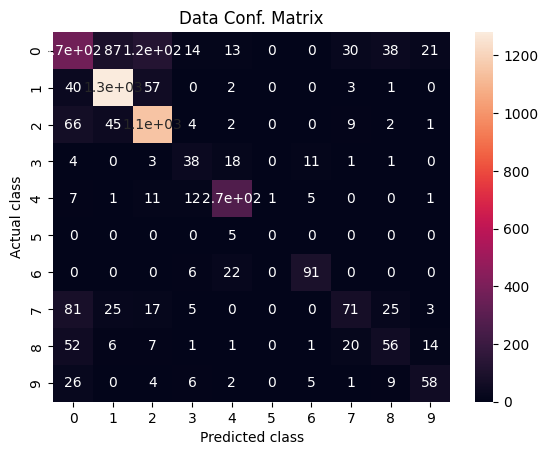

In [101]:
mat=confusion_matrix(target_true, target_pred)
sns.heatmap(mat, annot=True)
plt.title("Data Conf. Matrix")
plt.xlabel('Predicted class')
plt.ylabel('Actual class')